> ERC Starting Grant on COeXISTENCE between humans and machines in urban mobility.


<img src="../images/img_mileston1.png" alt="Milestone 1 Image" width="500" height="400">

# Title: Machine training using SAC algorithm
## Name: Anastasia
### Date: June 27, 2024
---

### Description

> In this notebook, we implement the training of independent machine agents using the SAC algorithm.
---

## Objective

> The purpose of this notebook is to understand whether SAC algorithm can train effectively our RL agents.
---

## Experiment Summary

### Network Architecture
- Csomor network
---

### Episodes
- 100 human learning - 200 machine learning
---

### Agents
| **Type**          |           |
|-------------------|---------------------|
| **Number**        | 8 humans(before mutation) -> 4 humans, 4 machines (after mutation) |
| **Total demand** | random |
---



### Origin and Destination Details
| **Origin Count**      | 2                            |
|-----------------------|------------------------------|
| **Destination Count** | 2                            |
| **Origin Pairing**    | 279952229#0, 115604053       |
| **Destination Pairing**| -115602933#2, -441496282#1     |
---

### Time to complete
- 1.20 h
---


    

### Hardware Utilized for Experiment Execution
| **Type of Machine** | Personal computer (or server) |
|----------------------|-------------------------------|
| **CPU**              | 12th Gen Intel(R) Core(TM) i7-1255U |
|                      | Cores: 10                   |
|                      | Sockets: 1                  |
|                      | Base Speed: 1.70 GHz        |
| **Memory**           | 16GB                          |
| **Disc (SSD)**       | 477 GB                        |
| **Operating System** | Windows 11                    |
---


### Imported libraries 

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensordict.nn import TensorDictModule, TensorDictSequential
import torch
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical, OneHotCategorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data import TensorDictReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, ValueOperator
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from torchrl.objectives import DiscreteSACLoss, SACLoss, SoftUpdate, ValueEstimators
from torchrl._utils import logger as torchrl_logger
from tensordict import TensorDictBase
from tqdm import tqdm
from torchrl.record.loggers import generate_exp_name, get_logger, Logger
from torchrl.record.loggers.wandb import WandbLogger
from torchrl.data.replay_buffers import LazyMemmapStorage
import time
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from environment import TrafficEnvironment
from keychain import Keychain as kc
from services.plotter import Plotter
from utilities import get_params

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hyperparameters specification

In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run

# Sampling
frames_per_batch = 4  # Number of team frames collected per training iteration
n_iters = 200  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 100  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# SAC
gamma = 0.99  # discount factor
tau = 0.02

### Environment Creation

In [3]:
params = get_params(kc.PARAMS_PATH)

In [4]:
env = TrafficEnvironment(params[kc.RUNNER], params[kc.ENVIRONMENT], params[kc.SIMULATOR], params[kc.AGENT_GEN], params[kc.AGENTS], params[kc.PHASE])

self.detectors_name is:  ['441496282#0', '441496282#1', '441496282#2', '441496282#3', '-115604050#2', '279952229#4', '279952229#5', '279952229#6', '410338471', '-819269916#2', '-115604057#1', '-115604047#1', '115604047#1', '115604057#1', '-115604051#2', '279952229#1', '279952229#2', '279952229#3', '-410338471', '-279952229#6', '154551772#1', '154551772#2', '154551772#3', '115604043#0', '-115602933#4', '-115602933#3', '-115602933#2', '115604050#1', '115604051#0', '-115602933#5', '115604043#1', '-279952229#1', '441496282#4', '-115604047#2', '-279952229#4', '115604048#1', '154551772#4', '154551772#5', '115604048#0']
[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


In [5]:
env.start()
env.reset()

({}, {})

### Human learning

In [6]:
num_episodes = 100

for episode in range(num_episodes):
    env.step()

### Mutation

In [7]:
env.mutation()

Mutation is about to happen!



c:\Users\Anastasia\anaconda3\envs\torchrl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now there are %s human agents.
 4


### Machine learning

In [8]:
env = PettingZooWrapper(
    env=env,
    use_mask=True,
    group_map=None,
    categorical_actions=True,
    done_on_any = False
)

In [9]:
env = TransformedEnv(
    env,
    RewardSum(
        in_keys=env.reward_keys,
        reset_keys=["_reset"] * len(env.group_map.keys()),
    ),
)

In [10]:
check_env_specs(env)

2024-07-17 12:54:38,050 [torchrl][INFO] check_env_specs succeeded!


In [11]:
reset_td = env.reset()

### Policy network

In [12]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1], 
        n_agent_outputs = env.full_action_spec[group, "action"].space.n,  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=4,
        num_cells=64,
        activation_class=torch.nn.Tanh,
    )

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "logits")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [13]:
policies = {}

for group, _agents in env.group_map.items():

    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "logits")],
        out_keys=[(group, "action")],
        distribution_class=Categorical,
        return_log_prob=True,
        log_prob_key=(group, "sample_log_prob"),
    )
    
    policies[group] = policy

### Critic network

In [14]:
critic_modules = {}
for group, agents in env.group_map.items():
    share_parameters_critic = False
    mappo = False  # IPPO if False

    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1],
        n_agent_outputs = env.full_action_spec[group, "action"].space.n, 
        n_agents = len(agents),
        centralised=mappo,
        share_params=share_parameters_critic,
        device=device,
        depth=4,
        num_cells=128,
        activation_class=torch.nn.Tanh,
    )

    value_module = ValueOperator(
        module=critic_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "action_value")],
    )
    critic_modules[group] = value_module

In [15]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    critic_modules[group](policies[group](reset_td))

In [16]:
policy = TensorDictSequential(*policies.values())

### Collector

In [17]:
collector = SyncDataCollector(
    env,
    policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    reset_at_each_iter=True,
    total_frames=total_frames,
)

### Replay Buffer

In [18]:
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffers[group] = TensorDictReplayBuffer(
        storage=LazyMemmapStorage(
            10*frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=10*minibatch_size,  # We will sample minibatches of this size
    )

### SAC loss function

In [19]:
losses = {}
optimizers = {}
target_net_updaters = {}

for group, _agents in env.group_map.items():
    
    loss_module = DiscreteSACLoss(
        actor_network=policies[group],
        qvalue_network=critic_modules[group],
        delay_qvalue=True, ## Whether to separate the target Q value networks from the Q value networks used for data collection.
        num_actions=env.action_spec[group]['action'].space.n,
        action_space=env.action_spec[group]['action'] ### changed this - don't know if it's correct
    )
    loss_module.set_keys(  # We have to tell the loss where to find the keys
        reward=(group, "reward"),  
        action_value=(group, "action_value"),
        action=(group, "action"), 
        done=(group, "done"),
        terminated=(group, "terminated"),
    )

    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    target_net_updaters[group] = SoftUpdate(loss_module, eps=1 - tau)


    losses[group] = loss_module

    optimizers[group] = torch.optim.Adam(loss_module.parameters(), lr)

### Training loop

In [20]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
sampling_start = time.time()
total_time = 0
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}


for i, tensordict_data in enumerate(collector):
    torchrl_logger.info(f"\nIteration {i}")

    sampling_time = time.time() - sampling_start

    current_frames = tensordict_data.numel()
    total_frames += current_frames

    for group, _agents in env.group_map.items():
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffers[group].extend(data_view)

    training_tds = []
    training_start = time.time()
    for _ in range(num_epochs):
        for group, _agents in env.group_map.items():
            for _ in range(frames_per_batch // minibatch_size):

                subdata = replay_buffers[group].sample()

                loss_vals = losses[group](subdata)
                training_tds.append(loss_vals.detach())

                loss_value = (
                    loss_vals["loss_actor"]
                    + loss_vals["loss_alpha"]
                    + loss_vals["loss_qvalue"]
                )

                loss_value.backward()

                total_norm = torch.nn.utils.clip_grad_norm_(
                    loss_module.parameters(), max_grad_norm
                )
                training_tds[-1].set("grad_norm", total_norm.mean())

                optimizers[group].step()
                optimizers[group].zero_grad()
                
                target_net_updaters[group].step()

    collector.update_policy_weights_()

    training_time = time.time() - training_start

    iteration_time = sampling_time + training_time
    total_time += iteration_time
    training_tds = torch.stack(training_tds)

    for group, _agents in env.group_map.items():
        done = tensordict_data.get(("next", group, "done"))  # Get done status for the group

        episode_reward_mean = (
            tensordict_data.get(("next", group, "reward"))[
                tensordict_data.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )

        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_2 = 0, episode_reward_mean_6 = 0, episode_reward_mean_1 = 0, episode_reward_mean_5 = 0:   0%|          | 0/200 [00:00<?, ?it/s]2024-07-17 12:54:42,623 [torchrl][INFO] 
Iteration 0
episode_reward_mean_2 = -3.183333396911621, episode_reward_mean_6 = -1.75, episode_reward_mean_1 = -1.8166667222976685, episode_reward_mean_5 = -3.0999999046325684:   0%|          | 1/200 [00:23<1:16:57, 23.20s/it]2024-07-17 12:55:04,990 [torchrl][INFO] 
Iteration 1
episode_reward_mean_2 = -3.700000047683716, episode_reward_mean_6 = -1.75, episode_reward_mean_1 = -1.8166667222976685, episode_reward_mean_5 = -4.433333396911621:   1%|          | 2/200 [00:43<1:10:10, 21.26s/it] 2024-07-17 12:55:24,734 [torchrl][INFO] 
Iteration 2
episode_reward_mean_2 = -3.683333396911621, episode_reward_mean_6 = -1.7333333492279053, episode_reward_mean_1 = -1.850000023841858, episode_reward_mean_5 = -3.6500000953674316:   2%|▏         | 3/200 [01:07<1:15:14, 22.92s/it]2024-07-17 12:55:50,102 [torchrl][INFO]

## Mean reward

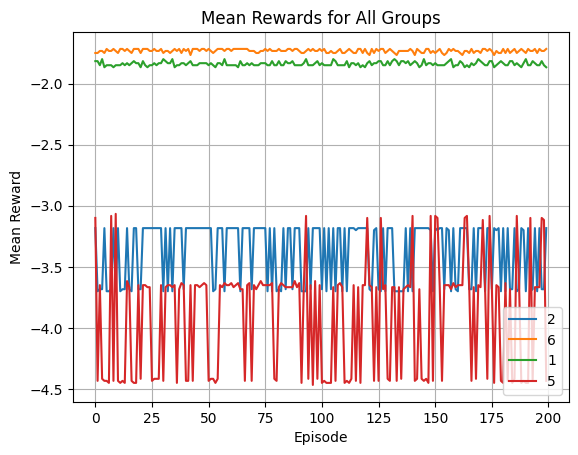

In [21]:
plt.figure()
for group in env.group_map.keys():
    rewards = episode_reward_mean_map[group]
    plt.plot(rewards, label=group)

plt.title('Mean Rewards for All Groups')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

## Losses

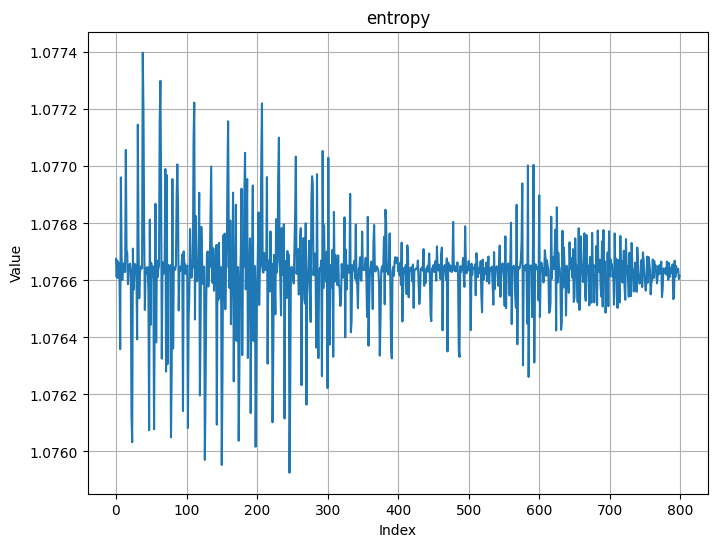

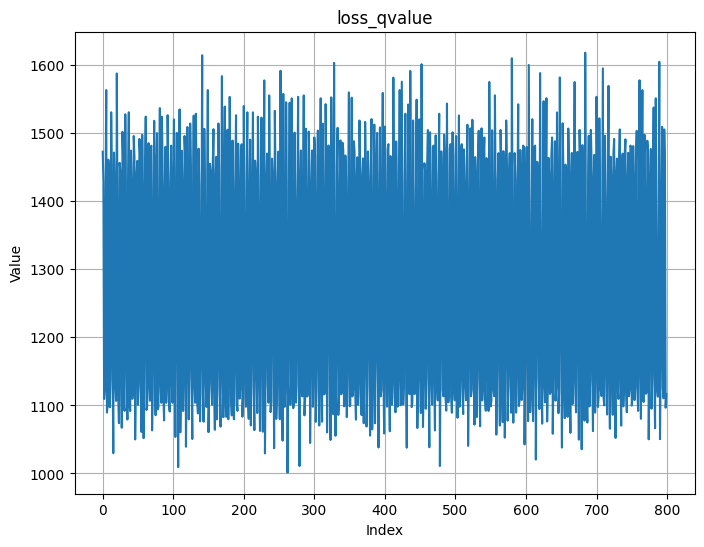

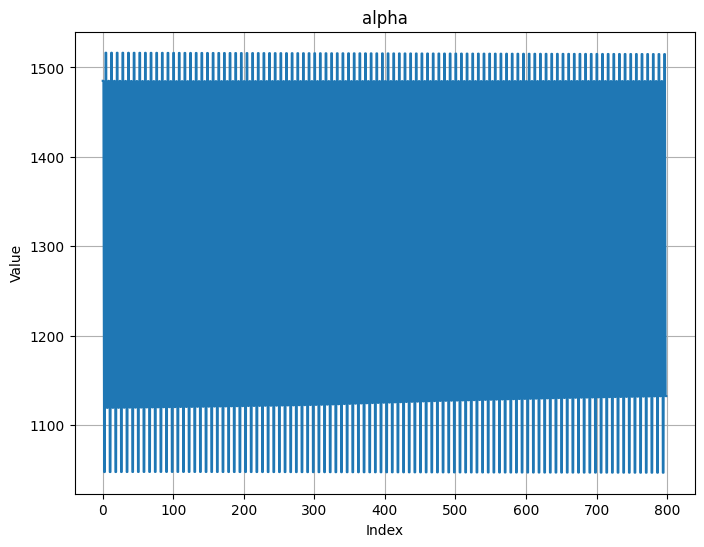

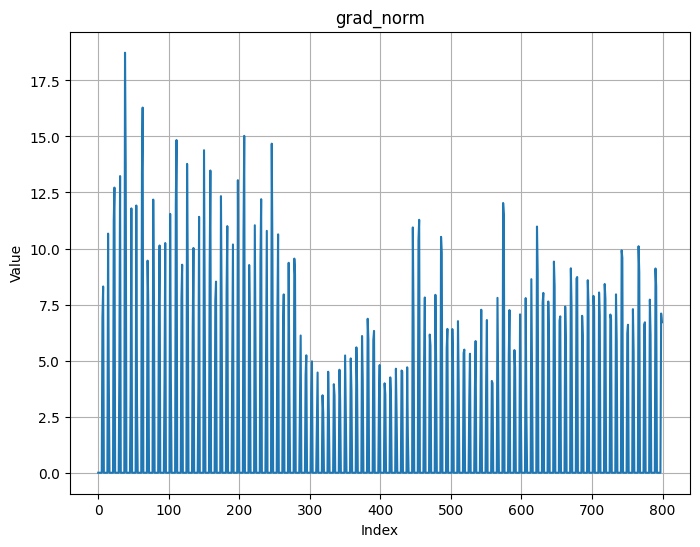

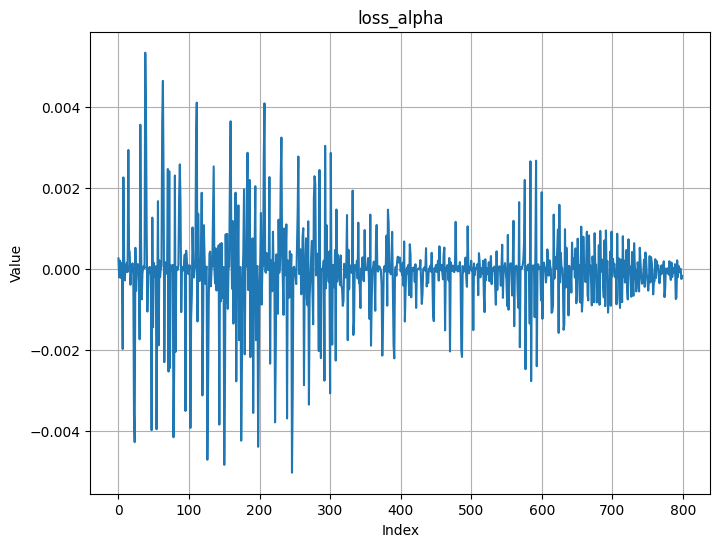

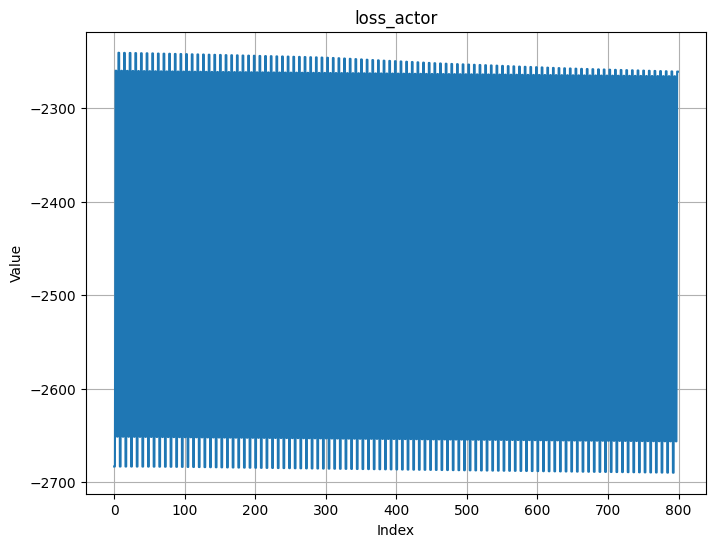

In [22]:
# Plot each tensor in separate figures
for key, tensor in training_tds.items():
    plt.figure(figsize=(8, 6))
    plt.plot(tensor.numpy())  # Convert tensor to numpy array and plot
    plt.title(key)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [23]:
from services import plotter

plotter(params[kc.PLOTTER])